In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import scipy.stats as st
import scipy.ndimage as nd
import scipy.signal as sg

def init(filename):
    file=sio.loadmat(filename) #On charge le fichier
    Nbobjets = int(max(file['objs_link'][3]))
    print("On a tracqué "+str(Nbobjets)+" particules")
    return file,Nbobjets
file, Nbobjets=init("results/prof.mat")
frequence=100
longueurminimale=1000
binning=2
agrandissement=10
def take(i,binning,agrandissement,frequence):
    """La fonction qui tracque la particule i"""
    PixelSize=binning*(6450/agrandissement)*1e-3 # en um
    x1=file['objs_link'][0,:][np.where(file['objs_link'][5,:]==i)]*PixelSize
    y1 = file['objs_link'][1,:][np.where(file['objs_link'][5,:]==i)]*PixelSize
    dureetrajectoire=x1.shape[0]
    print("Trajectory acquired for particle "+str(i))
    T=np.arange(dureetrajectoire)/frequence
    if dureetrajectoire>0:
        return x1-x1[0],y1-y1[0],T,dureetrajectoire
    else:
        return [0],[0],T,dureetrajectoire
def concatenate(ilist=np.arange(Nbobjets)+1):
    X=[0]
    Y=[0]
    N=0
    for i in ilist:
        a=take(i,binning,agrandissement,frequence)
        if a[-1]>longueurminimale:
            x1,y1,t,n=a
            X+=list(x1-x1[0]+X[-1])[1:]
            Y+=list(y1-y1[0]+Y[-1])[1:]
            N+=n
    T=np.arange(N)/frequence
    return np.array(X),np.array(Y),T,N


On a tracqué 40 particules


In [26]:
i=5
#1,5,16,11
x,y,T,N=take(i,binning,agrandissement,frequence)

Trajectory acquired for particle 5


In [45]:
xs,ys=nd.gaussian_filter(x,50),nd.gaussian_filter(y,50)
vx=xs[1:]-xs[:-1]
vy=ys[1:]-ys[:-1]
ax=vx[1:]-vx[:-1]
ay=vy[1:]-vy[:-1]
vx=vx[:-1]
vy=vy[:-1]
def autocorr(x,formsd=False):
    fftx = np.fft.fft(x, n=(x.shape[0]*2-1), axis=0)
    cfftx=np.conjugate(fftx)
    ret = np.real(np.fft.ifft(fftx*cfftx, axis=0))
    result = np.fft.fftshift(ret, axes=0)
    result = np.correlate(x, x, mode='full')
    if formsd:
        N=result.size//2+1
        return result[result.size//2:]/(N-np.arange(0,N))
    return result[result.size//2:]
vcorr=autocorr(vx)+autocorr(vy)
vcorr/=vcorr[0]

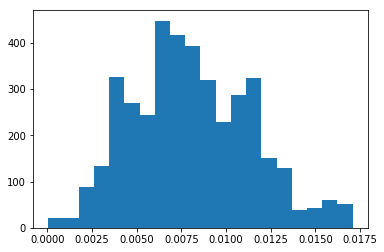

In [46]:
plt.hist((vx**2+vy**2)**0.5,20)
plt.show()

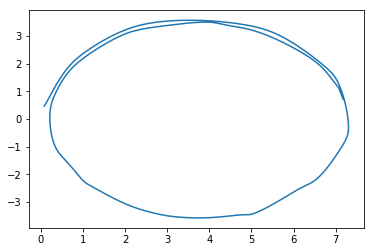

In [47]:
plt.plot(xs,ys)

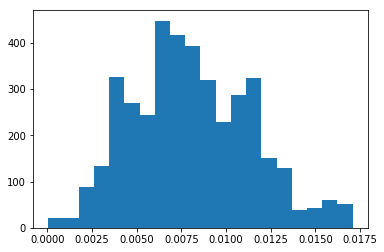

In [48]:
plt.hist((vx**2+vy**2)**0.5,20)
plt.show()

In [49]:
R=(vx**2+vy**2)**(3/2)/np.abs((vx*ay-vy*ax))

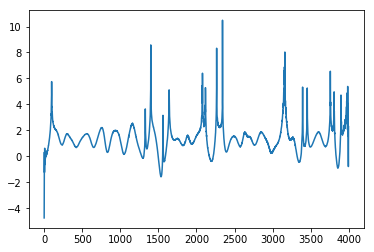

In [50]:
plt.plot(np.log(R))

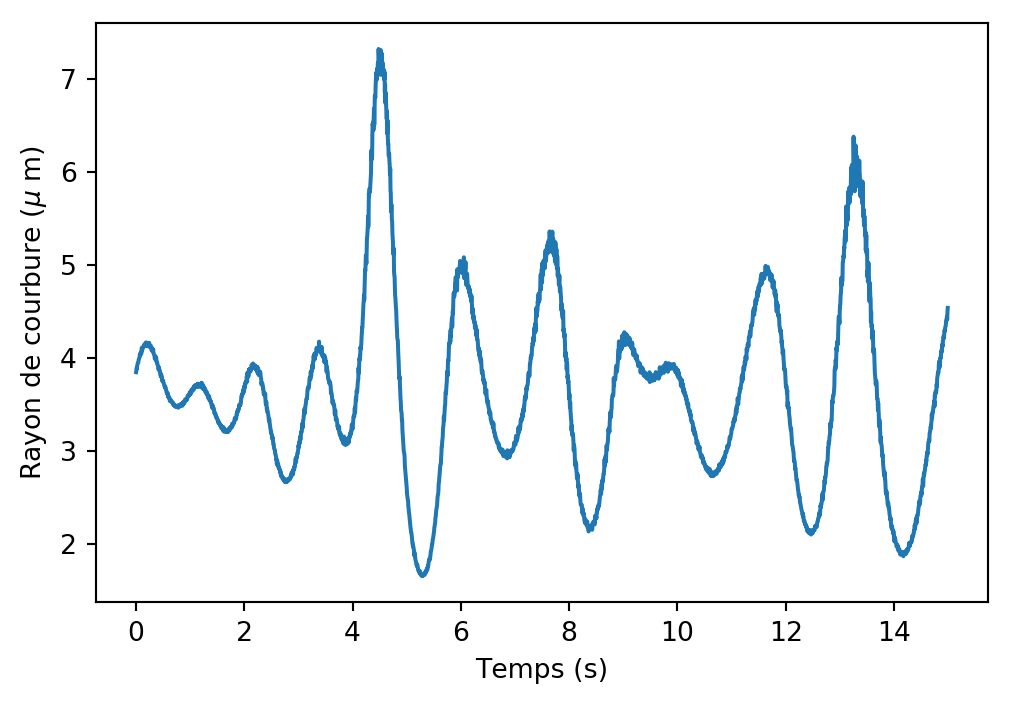

In [33]:
fig1, ax = plt.subplots()
ax.set_xlabel("Temps (s)")
ax.set_ylabel("Rayon de courbure ($\mu$ m)")
fig1.set_dpi(192)
ax.plot((T[500:3500]-T[500])/2,R[500:3500])
plt.show()
fig1.savefig("test.png")

In [34]:
def plot(X,Y,ax,fig):
    t = np.linspace(0,1,X.shape[0])
    dx=X[1:]-X[:-1]
    dy=Y[1:]-Y[:-1]
    dr=(dx**2+dy**2)**0.5
    dr1=dr/dr.max()
    points = np.array([X,Y]).transpose().reshape(-1,1,2)
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    lc = LineCollection(segs, cmap=plt.get_cmap('jet'))
    lc.set_array(dr)
    plt.gca().add_collection(lc)
    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    cbar = fig.colorbar(lc,label="Déplacement entre 2 images ($\mu$m)")


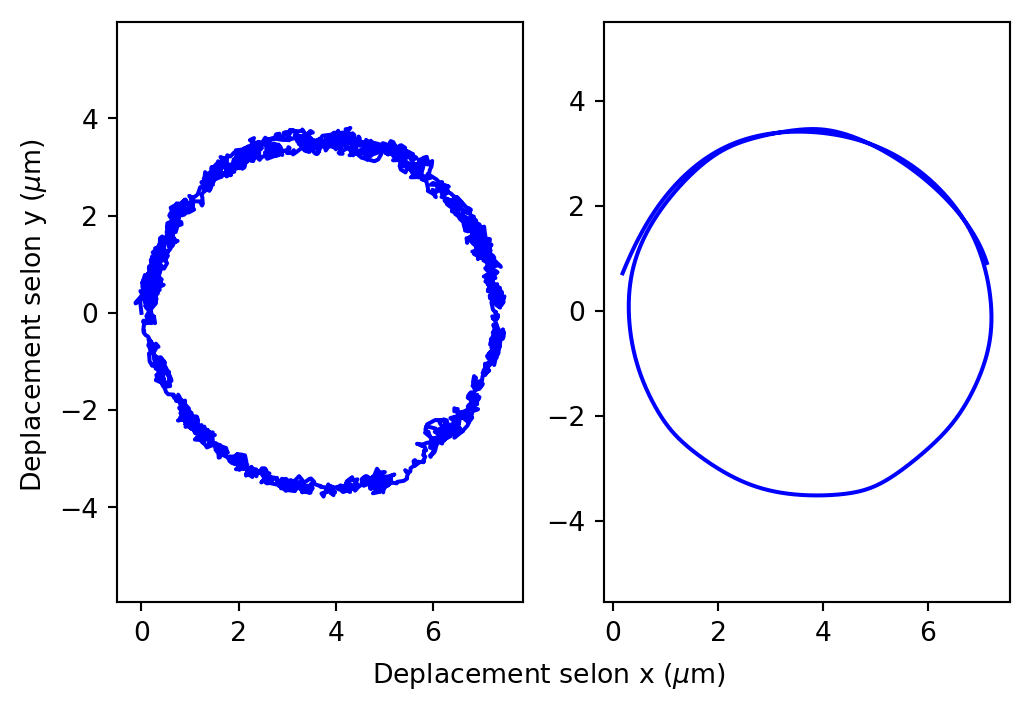

In [35]:
fig, ax = plt.subplots(1,2)
ax[0].plot(x,y,color='blue')
ax[0].axis('equal')
ax[1].plot(xs,ys,color='blue')
ax[1].axis('equal')
fig.set_dpi(192)
fig.text(0.5, 0.02, 'Deplacement selon x ($\mu$m)', ha='center')
fig.text(0.04, 0.5, 'Deplacement selon y ($\mu$m)', va='center', rotation='vertical')
#ax.axis('equal')
plt.show()
fig.savefig("Trajectory_lisse.png")

In [36]:
x.shape

(4000,)

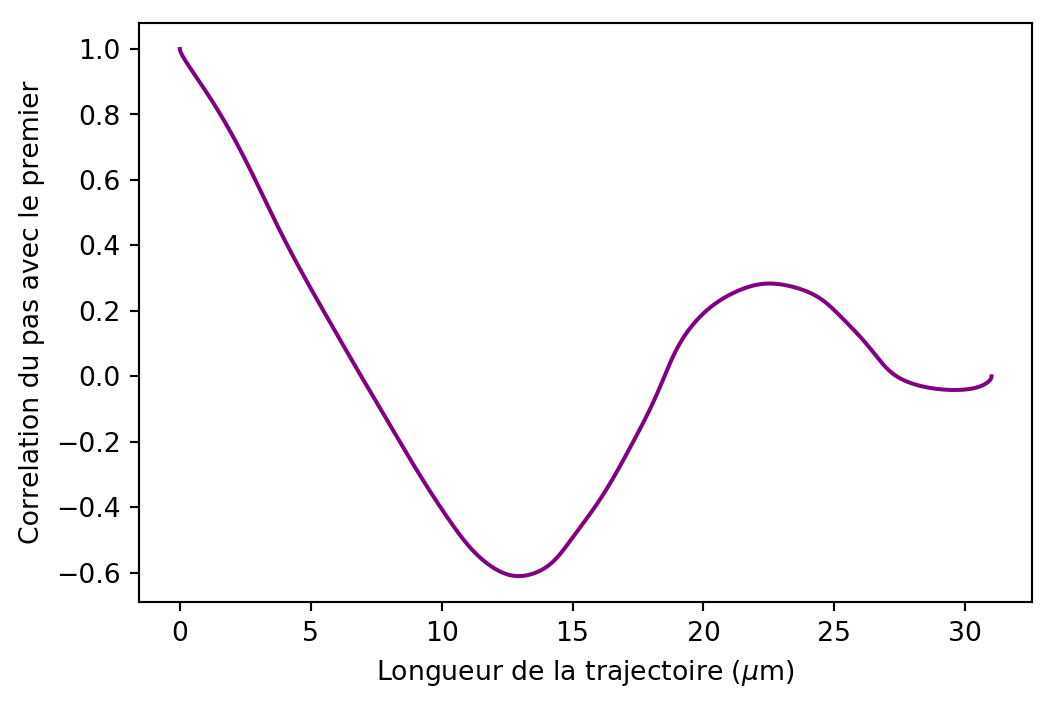

In [37]:
v=(vx**2+vy**2)**0.5
ux,uy=vx/v,vy/v
L=np.cumsum(v)
Corr=autocorr(ux)+autocorr(uy)
Corr/=Corr.max()
fig,ax=plt.subplots()
fig.set_dpi(192)
ax.plot(L,Corr,"-",color="purple")
ax.set_xlabel("Longueur de la trajectoire ($\mu$m)")
ax.set_ylabel("Correlation du pas avec le premier")
plt.show()
fig.savefig("Correlation_bactery.png")

In [38]:
vx.shape

(3998,)

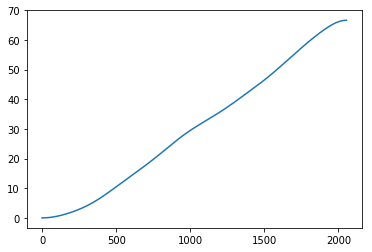

In [25]:
plt.plot(L)